In [477]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim
import warnings
warnings.filterwarnings('ignore')

# Генерация набора данных

In [478]:
SEED = 42
N_FEATURES = 100
X, y = make_classification(
    n_samples=100,
    n_features=N_FEATURES,
    n_informative=2,
    n_redundant=98,
    n_repeated=0,
    n_classes=2, 
    flip_y=0.1, 
    class_sep=0.6, 
    random_state=SEED
) # Максимально портим даннные

# Предобработка

In [479]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=SEED
)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train = torch.FloatTensor(X_train)
y_train = torch.FloatTensor(y_train).reshape(-1, 1)
X_test = torch.FloatTensor(X_test)
y_test = torch.FloatTensor(y_test).reshape(-1, 1)

# Модель

In [480]:
class MLP(nn.Module): # Усложняем модель для переобучения
    def __init__(self, input_size, dropout_rate=0.0):
        super(MLP, self).__init__()
        self.hidden1 = nn.Linear(input_size, 64)
        self.hidden2 = nn.Linear(64, 32)
        self.hidden3 = nn.Linear(32, 16)
        self.dropout = nn.Dropout(dropout_rate)
        self.output = nn.Linear(16, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        x = self.relu(self.hidden1(x))
        x = self.dropout(x)
        x = self.relu(self.hidden2(x))
        x = self.dropout(x)
        x = self.relu(self.hidden3(x))
        x = self.dropout(x)
        x = self.sigmoid(self.output(x))
        return x

In [481]:
# Функция обучения + сохранения метрик
def train_and_evaluate(model, optimizer, criterion, X_train, y_train, X_test, y_test, epochs=500):
    train_losses = []
    test_losses = []
    train_accuracies = []
    test_accuracies = []
    
    for epoch in range(epochs):
        # Обучение
        model.train()
        optimizer.zero_grad()
        train_outputs = model(X_train)
        train_loss = criterion(train_outputs, y_train)
        train_loss.backward()
        optimizer.step()
        
        # Метрики обучения
        train_preds = (train_outputs > 0.5).float()
        train_accuracy = (train_preds == y_train).float().mean()
        
        # Метрики тестирования
        model.eval()
        with torch.no_grad():
            test_outputs = model(X_test)
            test_loss = criterion(test_outputs, y_test)
            test_preds = (test_outputs > 0.5).float()
            test_accuracy = (test_preds == y_test).float().mean()
        
        train_losses.append(train_loss.item())
        test_losses.append(test_loss.item())
        train_accuracies.append(train_accuracy.item())
        test_accuracies.append(test_accuracy.item())
    
    return train_losses, test_losses, train_accuracies, test_accuracies

# Исследование оптимизаторов

In [482]:
optimizers = {
    'SGD': optim.SGD,
    'Adam': optim.Adam,
    'RMSProp': optim.RMSprop
}

criterion = nn.BCELoss()

# Тестирование без Dropout
results_no_dropout = {}

for opt_name, opt_class in optimizers.items():
   
    model = MLP(input_size=N_FEATURES, dropout_rate=0.0)
    
    if opt_name == 'SGD':
        optimizer = opt_class(model.parameters(), lr=0.01)
    else:
        optimizer = opt_class(model.parameters(), lr=0.001)
    
    train_losses, test_losses, train_accuracies, test_accuracies = train_and_evaluate(
        model, optimizer, criterion, X_train, y_train, X_test, y_test
    )
    
    results_no_dropout[opt_name] = {
        'train_losses': train_losses,
        'test_losses': test_losses,
        'train_accuracies': train_accuracies,
        'test_accuracies': test_accuracies
    }
    
    print(f"{opt_name}: ")
    print(f"  Точность на обучении: {train_accuracies[-1]:.4f}")
    print(f"  Точность на тесте: {test_accuracies[-1]:.4f}")
    print()

# Тестирование с Dropout
results_with_dropout = {}

for opt_name, opt_class in optimizers.items():
    print(f"Обучение {opt_name}...")
    
    model = MLP(input_size=N_FEATURES, dropout_rate=0.5)
    
    if opt_name == 'SGD':
        optimizer = opt_class(model.parameters(), lr=0.01)
    else:
        optimizer = opt_class(model.parameters(), lr=0.001)
    
    train_losses, test_losses, train_accuracies, test_accuracies = train_and_evaluate(
        model, optimizer, criterion, X_train, y_train, X_test, y_test
    )
    
    results_with_dropout[opt_name] = {
        'train_losses': train_losses,
        'test_losses': test_losses,
        'train_accuracies': train_accuracies,
        'test_accuracies': test_accuracies
    }
    
    print(f"{opt_name}: ")
    print(f"  Точность на обучении: {train_accuracies[-1]:.4f}")
    print(f"  Точность на тесте: {test_accuracies[-1]:.4f}")
    print()


SGD: 
  Точность на обучении: 0.9143
  Точность на тесте: 0.8333

Adam: 
  Точность на обучении: 1.0000
  Точность на тесте: 0.9667

RMSProp: 
  Точность на обучении: 0.9857
  Точность на тесте: 0.9000

Обучение SGD...
SGD: 
  Точность на обучении: 0.7143
  Точность на тесте: 0.8000

Обучение Adam...
Adam: 
  Точность на обучении: 0.9143
  Точность на тесте: 0.8333

Обучение RMSProp...
RMSProp: 
  Точность на обучении: 0.9429
  Точность на тесте: 0.8333



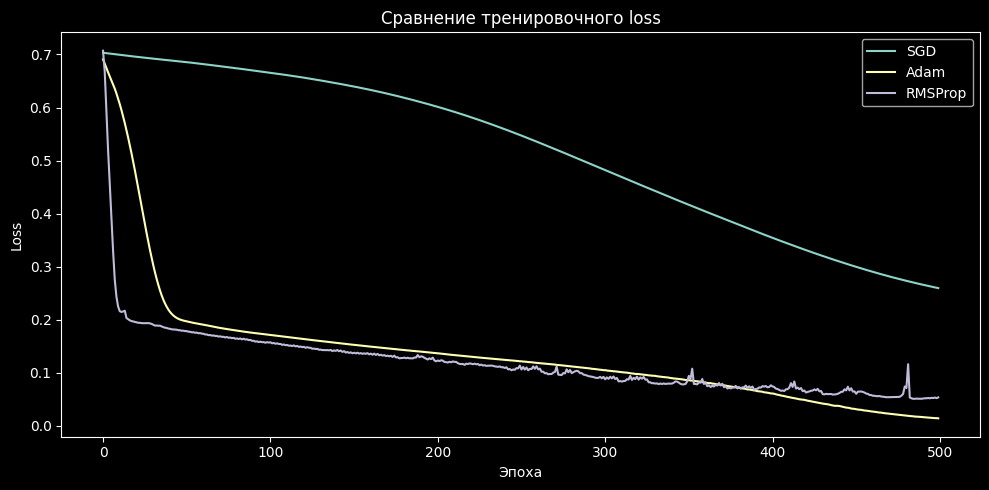

In [483]:
plt.figure(figsize=(10, 5))

for idx, opt_name in enumerate(optimizers.keys()):
    train_loss_no = results_no_dropout[opt_name]['train_losses']

    plt.plot(train_loss_no, label=f'{opt_name}')

    plt.title('Сравнение тренировочного loss')

    plt.legend()
    
    plt.xlabel('Эпоха')
    plt.ylabel('Loss')

plt.tight_layout()
plt.show()

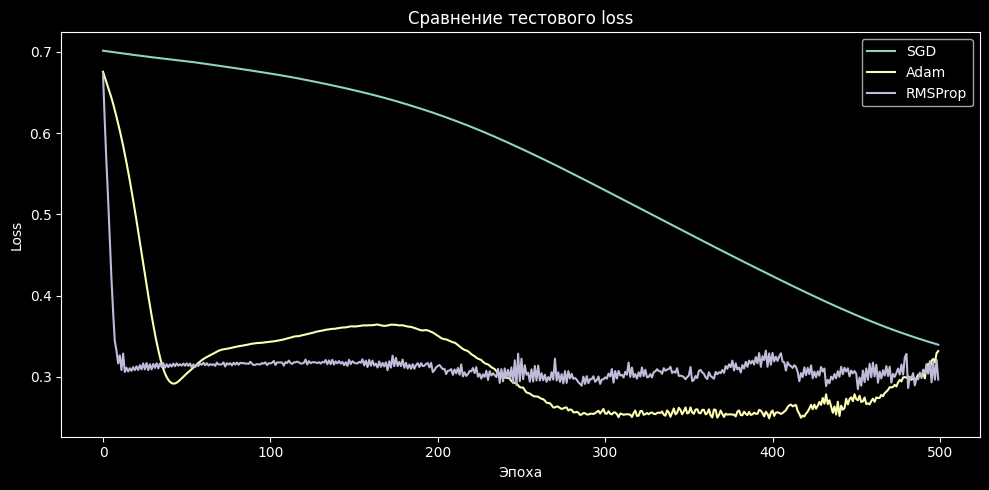

In [484]:
plt.figure(figsize=(10, 5))

for idx, opt_name in enumerate(optimizers.keys()):
    train_loss_no = results_no_dropout[opt_name]['test_losses']

    plt.plot(train_loss_no, label=f'{opt_name}')

    plt.title('Сравнение тестового loss')

    plt.legend()
    
    plt.xlabel('Эпоха')
    plt.ylabel('Loss')

plt.tight_layout()
plt.show()

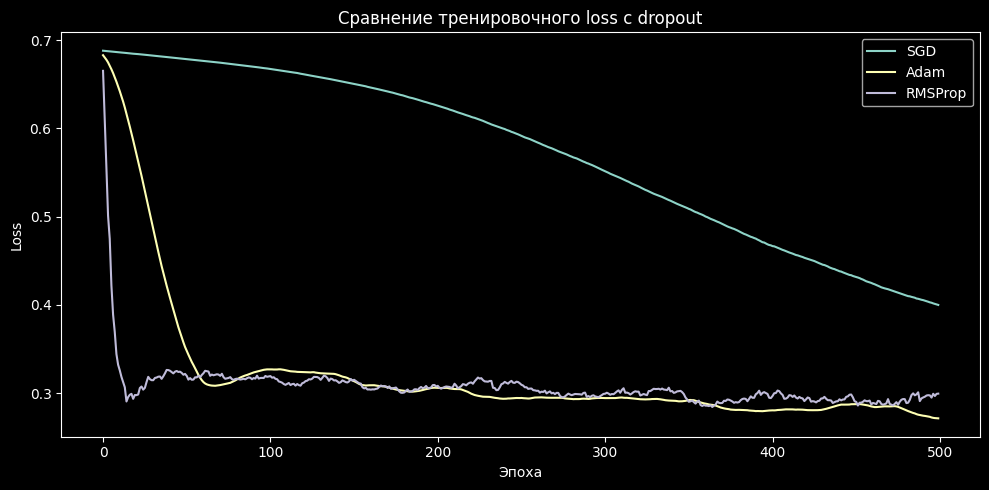

In [485]:
plt.figure(figsize=(10, 5))

for idx, opt_name in enumerate(optimizers.keys()):
    train_loss_with = results_with_dropout[opt_name]['test_losses']

    plt.plot(train_loss_with, label=f'{opt_name}')

    plt.title('Сравнение тренировочного loss c dropout')

    plt.legend()
    
    plt.xlabel('Эпоха')
    plt.ylabel('Loss')

plt.tight_layout()
plt.show()

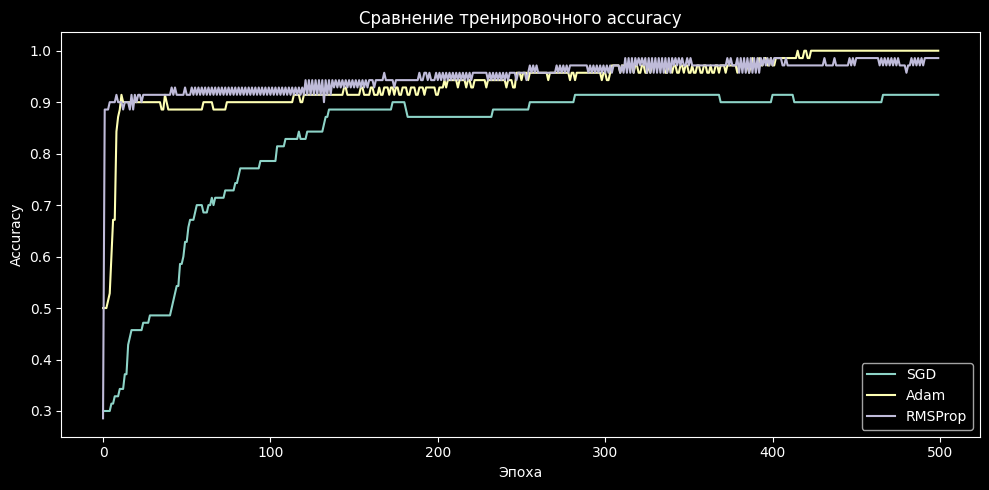

In [486]:
plt.figure(figsize=(10, 5))

for idx, opt_name in enumerate(optimizers.keys()):
    train_acc_no = results_no_dropout[opt_name]['train_accuracies']

    plt.plot(train_acc_no, label=f'{opt_name}')

    plt.title('Сравнение тренировочного accuracy')

    plt.legend()
    
    plt.xlabel('Эпоха')
    plt.ylabel('Accuracy')

plt.tight_layout()
plt.show()

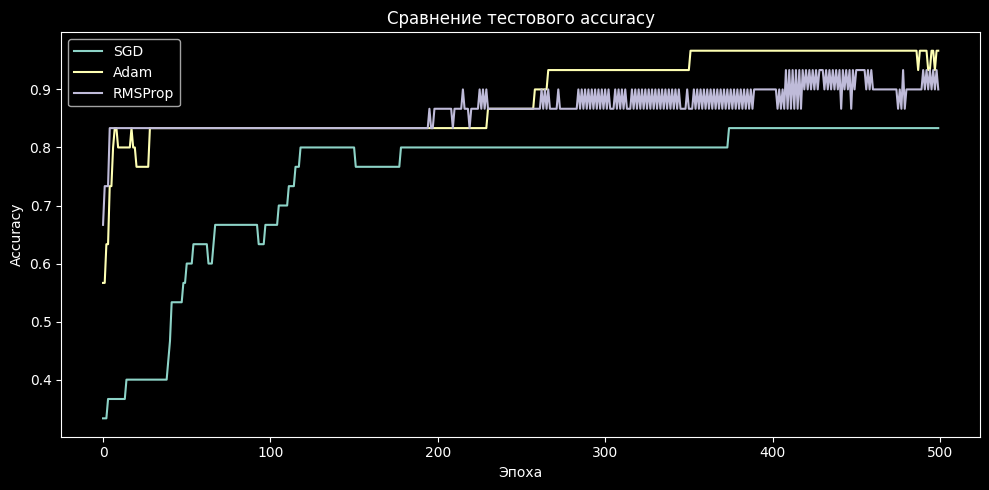

In [487]:
plt.figure(figsize=(10, 5))

for idx, opt_name in enumerate(optimizers.keys()):
    train_acc_no = results_no_dropout[opt_name]['test_accuracies']

    plt.plot(train_acc_no, label=f'{opt_name}')

    plt.title('Сравнение тестового accuracy')

    plt.legend()
    
    plt.xlabel('Эпоха')
    plt.ylabel('Accuracy')

plt.tight_layout()
plt.show()

Видим, что PMSProp обеспечивает наиболее быструю сходимость; SGD - наиболее стабильную/гладкую, но медленную сходимость; а Adam - выдерживает баланс между скоростью и стабильностью сходимости, но гораздо легче переобучется. 

В конечном счете, adam в модели с dropout достигает наилучшего соответствия данным. 

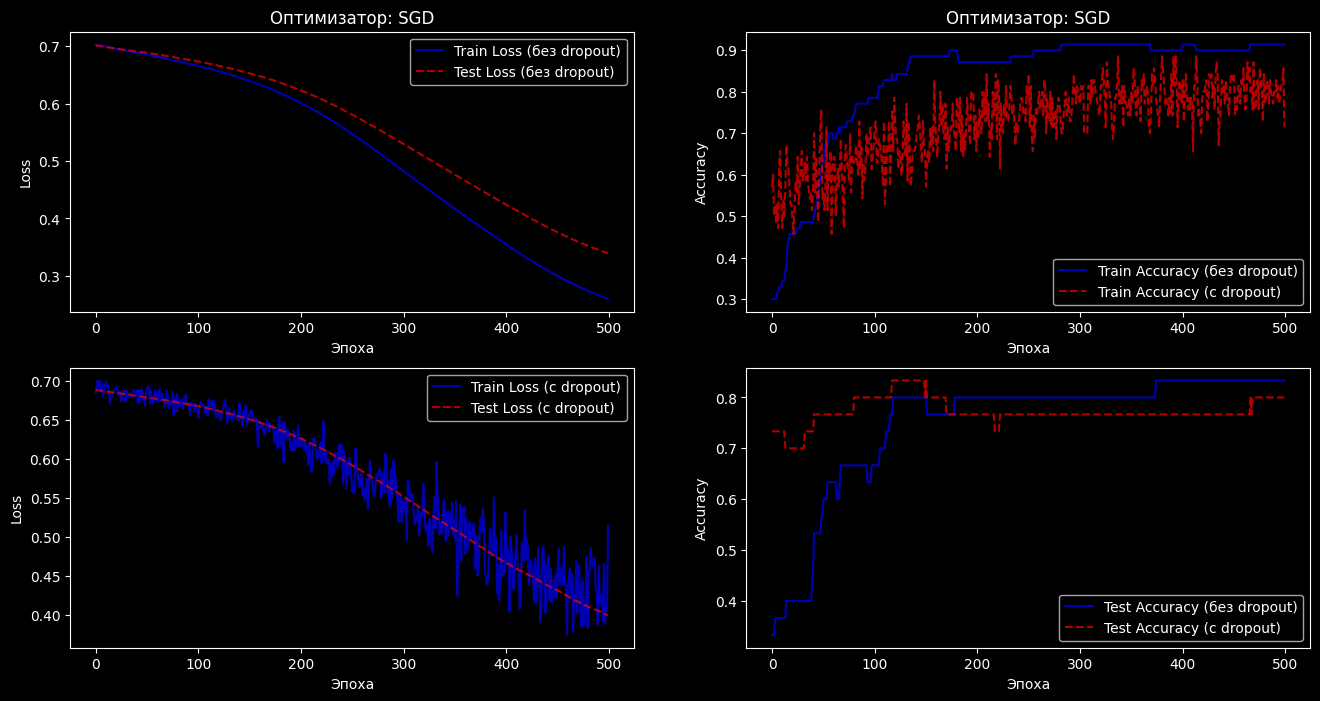

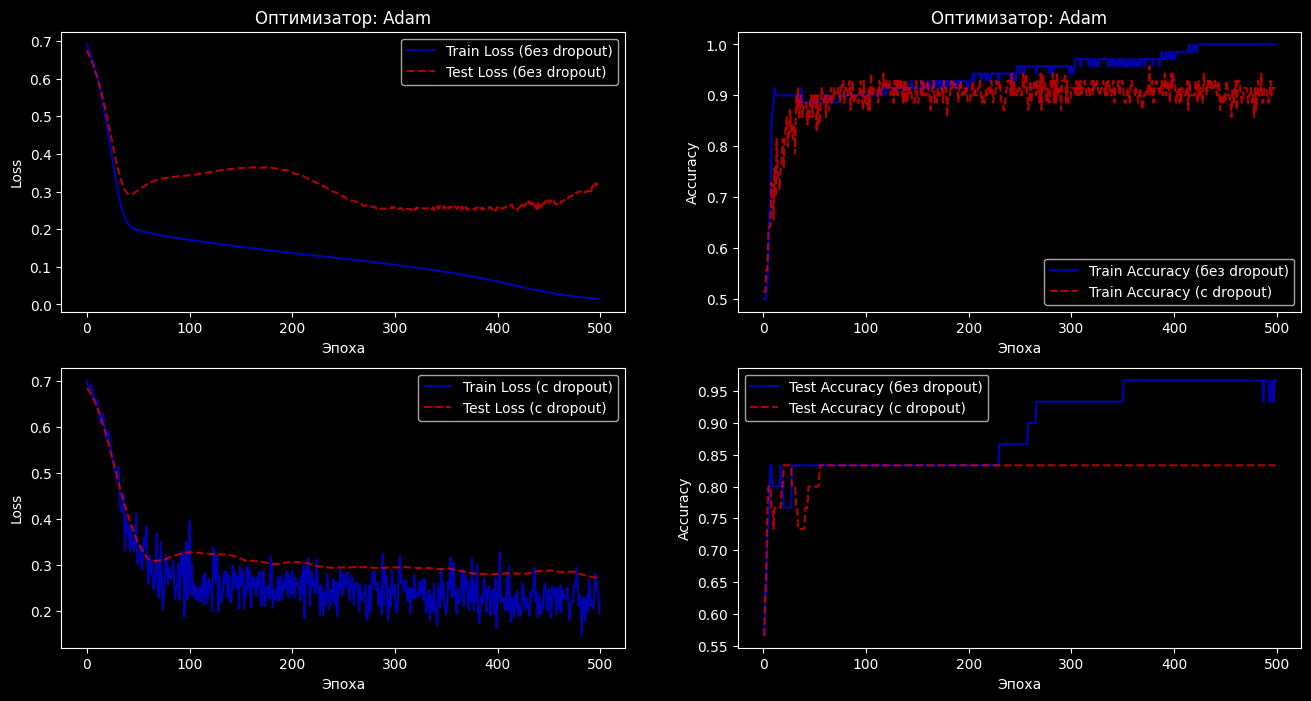

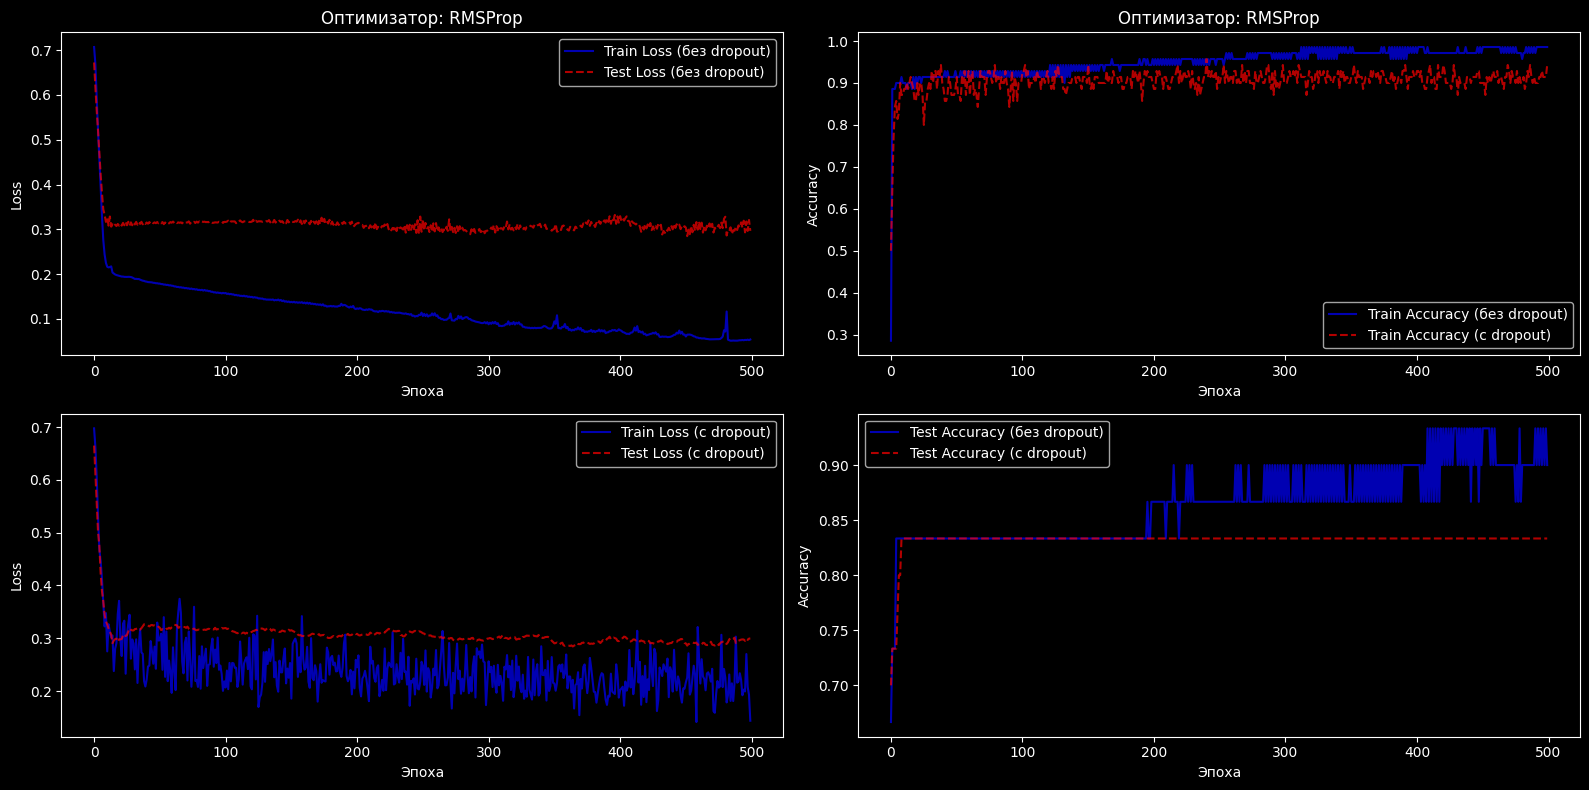

In [488]:
# Визуализация
for idx, opt_name in enumerate(optimizers.keys()):

    plt.figure(figsize=(16, 8))

    train_loss_no = results_no_dropout[opt_name]['train_losses']
    test_loss_no = results_no_dropout[opt_name]['test_losses']
    train_loss_with = results_with_dropout[opt_name]['train_losses']
    test_loss_with = results_with_dropout[opt_name]['test_losses']
    
    plt.subplot(2, 2, 1)
    
    plt.plot(train_loss_no, label='Train Loss (без dropout)', color='blue', alpha=0.7)
    plt.plot(test_loss_no, label='Test Loss (без dropout)', color='red', alpha=0.7, linestyle='--')

    plt.title(f'Оптимизатор: {opt_name}')

    plt.legend()
    
    plt.xlabel('Эпоха')
    plt.ylabel('Loss')

    
    plt.subplot(2, 2, 3)

    plt.plot(train_loss_with, label='Train Loss (с dropout)', color='blue', alpha=0.7)
    plt.plot(test_loss_with, label='Test Loss (с dropout)', color='red', alpha=0.7, linestyle='--')
    
    plt.legend()
    
    plt.xlabel('Эпоха')
    plt.ylabel('Loss')


    train_acc_no = results_no_dropout[opt_name]['train_accuracies']
    test_acc_no = results_no_dropout[opt_name]['test_accuracies']
    train_acc_with = results_with_dropout[opt_name]['train_accuracies']
    test_acc_with = results_with_dropout[opt_name]['test_accuracies']
    
    plt.subplot(2, 2, 2)
    
    plt.plot(train_acc_no, label='Train Accuracy (без dropout)', color='blue', alpha=0.7)
    plt.plot(train_acc_with, label='Train Accuracy (с dropout)', color='red', alpha=0.7, linestyle='--')

    plt.title(f'Оптимизатор: {opt_name}')

    plt.legend()
    
    plt.xlabel('Эпоха')
    plt.ylabel('Accuracy')

    
    plt.subplot(2, 2, 4)

    plt.plot(test_acc_no, label='Test Accuracy (без dropout)', color='blue', alpha=0.7)
    plt.plot(test_acc_with, label='Test Accuracy (с dropout)', color='red', alpha=0.7, linestyle='--')
    
    plt.legend()
    
    plt.xlabel('Эпоха')
    plt.ylabel('Accuracy')

plt.tight_layout()
plt.show()

В свою очередь, добавление dropout приводит к небольшому понижению точности, но позволяет модели лучше работать с шумом и предотвращает переобучение